This CNN Research Project is based on the joint works of Zheng Cao, Wenyu Du, and Kirill V. Golubnichiy.

In [17]:
# import libraries and mount to google drive
import sys
import os
import csv
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torch.optim as optim
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# set up DEVICE and import data
DEBUG = True
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() and not DEBUG else 'cpu'

mini_data = pd.read_csv('/content/mini.csv')
mini2_data = pd.read_csv('/content/mini2.csv')
train_data = pd.read_csv('/content/train.csv')
valid_data = pd.read_csv('/content/valid.csv')
test_data = pd.read_csv('/content/test.csv')

input_file = '/content/train.csv'

In [19]:
# Splitting Data for Training
DEVICE = get_device()

TRAIN_INPUT_FILE = '/content/train.csv'
TEST_INPUT_FILE = '/content/test.csv'
VAL_INPUT_FILE = '/content/valid.csv'

X_train, y_train = import_data(TRAIN_INPUT_FILE, DEVICE)
X_test, y_test = import_data(TEST_INPUT_FILE, DEVICE)
X_val, y_val = import_data(VAL_INPUT_FILE, DEVICE)

print("Importing Data...")
X_train, y_train = import_data(TRAIN_INPUT_FILE)


print(X_train.shape) # torch.Size([1, 70322, 13])

print(y_train.shape) # torch.Size([70322, 1])

Importing Data...
torch.Size([1, 70322, 13])
torch.Size([70322, 1])


In [20]:
class OptionDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.data.iloc[idx]
        if self.transform:
            row = self.transform(row)
        return row


def get_device():
    if torch.cuda.is_available() and not debug:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device


def init_weights(m):
    print(m)

# Add the parse_data function
def import_data(input_file, device='cpu', split=False):
    input_df = np.array((list(csv.reader(open(input_file, "r"))))[1:], dtype=object)

    size_train = len(input_df)

    ml_th = 0.52
    tp = 0
    tn = 0
    ps = 0

    min_norm = 10000.0
    max_norm = -10000.0

    for i in range(len(input_df)):
        for j in range(4, 23):
            input_df[i][j] = float(input_df[i][j])
        # label
        real0 = (input_df[i][6] + input_df[i][9]) / 2
        label = 1 if input_df[i][17] >= real0 - 0.000000001 else 0

        forecast = 1 if input_df[i][15] >= real0 - 0.000000001 else 0
        input_df[i][3] = forecast
        input_df[i][1] = input_df[i][17] / real0 - 1.0  # RoI
        input_df[i][17] = label
        ps += forecast

        if forecast == 1 and label == 1:
            tp += 1
        elif forecast == 0 and label == 0:
            tn += 1
        # normalization
        # print(input_df[i][0])
        strike = float(input_df[i][0].split(' ')[-2][1:])
        s_ask = input_df[i][10] - strike
        s_bid = input_df[i][11] - strike
        s = (input_df[i][10] + input_df[i][11]) / 2
        norm = (s - strike) / (s + strike)
        if norm > max_norm:
            max_norm = norm
        if norm < min_norm:
            min_norm = norm
        input_df[i][2] = norm

        total = 0.0
        for j in range(4, 10):
            total += input_df[i][j]
        av = total / 6.0
        sigma = 0.0
        for j in range(4, 10):
            sigma += (input_df[i][j] - av) ** 2
        sigma = math.sqrt(sigma / 5.0)
        for j in range(4, 10):
            input_df[i][j] = (input_df[i][j] - av) / sigma
        input_df[i][10] = (s_ask - av) / sigma
        input_df[i][11] = (s_bid - av) / sigma
        input_df[i][15] = (input_df[i][15] - av) / sigma
        input_df[i][16] = (input_df[i][16] - av) / sigma
        # print(input_df[i])

    x = torch.Tensor(input_df[0:size_train, 4:17].astype(float)).float().to(device)
    # print(x)
    y = torch.from_numpy(input_df[0:size_train, 17:18].astype(float)).float().to(device)

    if split:
        x_train, x_val, x_test, y_train, y_val, y_test = data_split(x, y)
        x_train = x_train.reshape((1, x_train.shape[0], x_train.shape[1]))
        x_val = x_val.reshape((1, x_val.shape[0], x_val.shape[1]))
        x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1]))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x = x.reshape((1, x.shape[0], x.shape[1]))
        return x, y


def data_split(x, y):
    n = len(y)
    random_indices = torch.randperm(n)
    num_train = int(n * 0.7)
    num_val = int(n * 0.2)

    X_train = x[random_indices[:num_train]]
    X_train = y[random_indices[:num_train]]
    X_val = x[random_indices[num_train:num_train + num_val]]
    y_val = y[random_indices[num_train:num_train + num_val]]
    X_test = x[random_indices[num_train + num_val:]]
    y_test = y[random_indices[num_train + num_val:]]
    return X_train, X_val, X_test, y_train, y_val, y_test



X, y = import_data(input_file)
print(X.shape)  # torch.Size([70322, 11, 13])
print(y.shape)  # torch.Size([70322, 1])
print(y[:10])




torch.Size([1, 70322, 13])
torch.Size([70322, 1])
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]])


In [21]:
# CNN Model Class
class CNNModel(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv2 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv3 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv4 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv5 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.pool = nn.MaxPool1d(1, 3)
        self.sigmoid = nn.Sigmoid()
        self.to(device)


    def forward(self, x):
        dropped_one, n, d = x.shape
        x = x.reshape((1, 1, n, d))
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        dopped_one_1, dropped_one_2, n, d = x.shape
        x = x.reshape((1, n, d))
        x = self.pool(x)
        # print(x.shape)
        x = self.sigmoid(x)
        return x

In [22]:
def train(model, x_train, y_train, n_epochs=5, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    losses = []
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        output_train = model(x_train)
        output_train = output_train.reshape((output_train.shape[1], output_train.shape[2]))
        # print(output_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()
        loss_value = loss_train.item()
        losses.append(loss_value)
        if epoch % 100 == 0:
            print("Epoch {}: loss = {}".format(str(epoch), str(loss_value)))

        if len(output_train.nonzero()) == 0:        # not sure if this works
            print("Epoch {}: all zero output!".format(str(epoch)))

    return losses

def calc_acc(y_pred, y, th=0.52):
    #tp = 0
    #tn = 0
    size = len(y)
    #for i in range(size):
    #    if y_pred[i] >= th and y[i] == 1:
    #        tp += 1
    #    elif y_pred[i] < th and y[i] == 0:
    #        tn += 1
    #return float(tp + tn)*100/size
    with torch.no_grad():
        #print(y)
        #print(y_pred)
        y_th = torch.heaviside(y_pred - torch.tensor(th).expand_as(y_pred), torch.tensor(1.0).expand_as(y_pred))
        tp = torch.sum(torch.logical_and(y_th, y))
        p_pred = torch.sum(y_th)
        p_label = torch.sum(y)
        #print(y_th)
        #print(torch.logical_xor(y_th, y))
        acc = float(size - torch.sum(torch.logical_xor(y_th, y)))*100/size
        prec = float(tp)*100/p_pred
        rec = float(tp)*100/p_label
    return [acc, prec, rec]


In [23]:
# CNN Training
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNNModel(DEVICE)

  1%|          | 1/100 [00:00<01:12,  1.36it/s]

Epoch 0: loss = 0.8428158760070801


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


Text(0, 0.5, 'Loss')

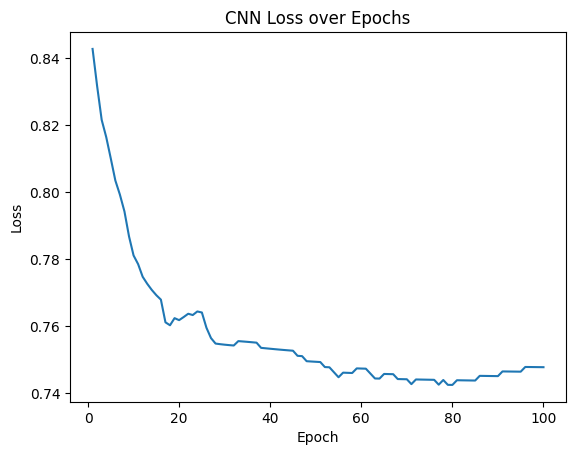

In [24]:
# print loss visualization
# print(losses)
# plot
losses = train(model, X_train, y_train, n_epochs=100, lr=0.001)
plot_x = np.arange(1, 101)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.title("CNN Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")


Hyperparameter tuning
best threshold:0.5
51.483544303797466
Evaluate on training data with best threshold
[52.65350814823242, tensor(55.4389), tensor(43.7941)]
Evaluate on testing data with best threshold
[51.901336073997946, tensor(50.6883), tensor(56.6111)]


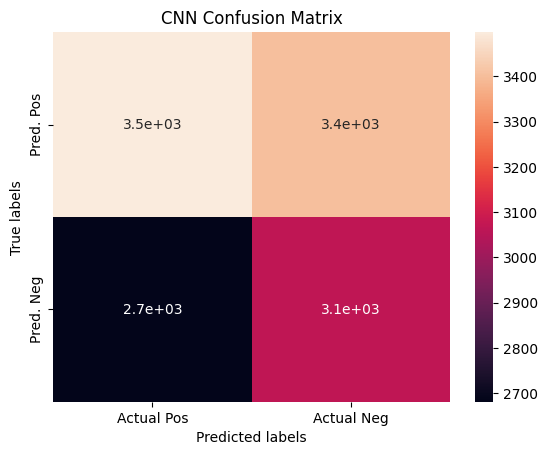

In [25]:

print("Hyperparameter tuning")
best_th = 0.0
best_acc = 0.0
with torch.no_grad():
    for i in range(100):
        th = i / 100.0
        y_prediction = model(X_val)
        y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
        evauluation_result = calc_acc(y_prediction, y_val, th=th)
        accuracy = evauluation_result[0]
        if accuracy > best_acc:
            best_acc = accuracy
            best_th = th
    print("best threshold:" + str(best_th))
    print(best_acc)



print("Evaluate on training data with best threshold")
with torch.no_grad():
    y_prediction = model(X_train)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evauluation_result = calc_acc(y_prediction, y_train)
    print(evauluation_result)


# confusion matrix
# Confusion Matrix on submission_model_XX
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

def plot_model(model_name, predictions, labels):
    y_true = labels
    y_pred = predictions
    x = confusion_matrix(y_true, y_pred)
    tp = x[1][1]
    fp = x[0][1]
    tn = x[0][0]
    fn = x[1][0]
    ax= plt.subplot()
    plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('CNN Confusion Matrix')

with torch.no_grad():
    y_prediction = model(X_test)
    y_prediction_confusion = y_prediction.reshape(y_prediction.shape[1])
    y_th = torch.heaviside(y_prediction_confusion
                           - torch.tensor(best_th).expand_as(y_prediction_confusion),
                           torch.tensor(1.0).expand_as(y_prediction_confusion))
    y_test_confusion = y_test.reshape(y_test.shape[0])
    plot_model("", y_th, y_test_confusion)

print("Evaluate on testing data with best threshold")
with torch.no_grad():
    y_prediction = model(X_test)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evauluation_result = calc_acc(y_prediction, y_test, th=best_th)
    print(evauluation_result)